Loading dataset...


Saving drug_consumption.csv to drug_consumption.csv
Dataset loaded successfully!
Preprocessing data...
Data preprocessing completed!

Starting model evaluation...

Dataset Information:
Total samples: 1885
Training set size: 1508 (80.00%)
Testing set size: 377 (20.00%)

Evaluating models for Impulsive

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Ridge Regression...

Evaluating models for SS

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Ridge Regression...

Results for Impulsive:
Random Forest:
Mean RMSE: 0.8272
Normalized Accuracy (1 - RMSE / range): 84.84%
RMSE Std: 0.0359
Gradient Boosting:
Mean RMSE: 0.8386
Normalized Accuracy (1 - RMSE / range): 84.63%
RMSE Std: 0.0369
XGBoost:
Mean RMSE: 0.8364
Normalized Accuracy (1 - RMSE / range): 84.67%
RMSE Std: 0.0339
Ridge Regression:
Mean RMSE: 0.8360
Normalized Accuracy (1 - RMSE / range): 84.68%
RMSE Std: 0.0340

Results for SS:
Random Forest:
Mean RMSE

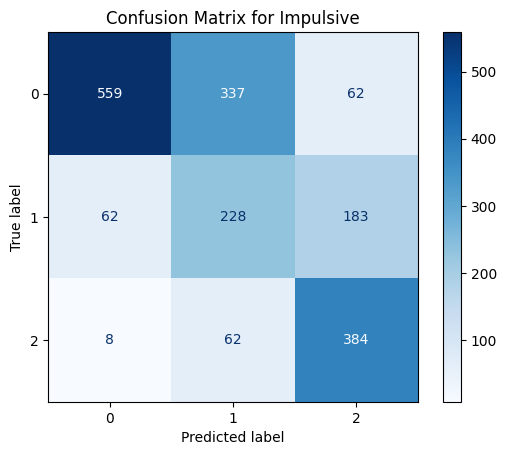


Best model for SS: Ridge Regression with RMSE: 0.7601
Creating confusion matrix for SS...


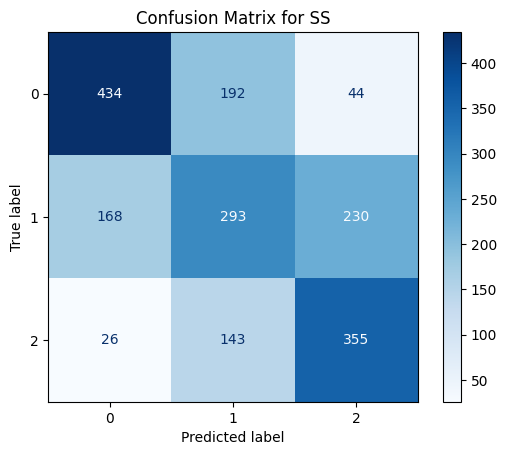

Analysis complete!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

def advanced_preprocessing(data):
    #features used for prediction
    features = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Education', 'Age', 'Ethinicity',
                'Alcohol', 'Amphete', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
                'Ecstacy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA']
    targets = ['Impulsive', 'SS']

    X = data[features]
    y = data[targets]

    #column type error solution
    global numerical_columns, categorical_columns
    categorical_columns = X.select_dtypes(include=['object']).columns
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

    #preprocessing the data
    preprocessor = ColumnTransformer(
        transformers=[('num', StandardScaler(), numerical_columns),
                      ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])

    return X, y, preprocessor

def create_model_pipelines():
   #hyperparameter tuning
    models = {
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [None, 10, 20],
                'model__min_samples_split': [2, 5, 10]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'model__n_estimators': [100, 200],
                'model__learning_rate': [0.01, 0.1],
                'model__max_depth': [3, 5]
            }
        },
        'XGBoost': {
            'model': XGBRegressor(random_state=42),
            'params': {
                'model__n_estimators': [100, 200],
                'model__learning_rate': [0.01, 0.1],
                'model__max_depth': [3, 5]
            }
        },
        'Ridge Regression': {
            'model': Ridge(),
            'params': {
                'model__alpha': [0.1, 1.0, 10.0]
            }
        }
    }

    return models

def evaluate_models(X, y, preprocessor):
    #data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    print("\nDataset Information:")
    print(f"Total samples: {len(X)}")
    print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
    print(f"Testing set size: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")

    #pipeline creation
    models = create_model_pipelines()

    results = {}
    best_models = {}

    #run each model in individually
    for target in y.columns:
        print(f"\nEvaluating models for {target}")
        target_results = {}
        y_train_target = y_train[target]
        y_test_target = y_test[target]
        best_rmse = float('inf') #float to avoid handling error and stores it as postive infinity
        best_model_name = None
        best_model = None

        for model_name, model_info in models.items():
            print(f"\nTraining {model_name}...")

            # Create pipeline
            pipeline = Pipeline([('preprocessor', preprocessor),
                                 ('model', model_info['model'])])

            # Perform Grid Search with Cross-Validation
            grid_search = GridSearchCV(
                pipeline,
                param_grid=model_info['params'],
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )

            # Fit the model
            grid_search.fit(X_train, y_train_target)

            # Get best model
            best_model_candidate = grid_search.best_estimator_

            # Perform cross-validation
            cv_scores = cross_val_score(
                best_model_candidate,
                X_train,
                y_train_target,
                cv=5,
                scoring='neg_mean_squared_error'
            )

            # Calculate metrics
            mse_scores = -cv_scores
            rmse_scores = np.sqrt(mse_scores)

            mean_rmse = rmse_scores.mean()
            target_results[model_name] = {
                'Best Params': grid_search.best_params_,
                'Mean RMSE': mean_rmse,
                'RMSE Std': rmse_scores.std()
            }

            #check for least rmse value or best rmse value
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_model_name = model_name
                best_model = best_model_candidate

        #best model for prediction
        best_models[target] = {
            'Model': best_model,
            'Model Name': best_model_name,
            'Mean RMSE': best_rmse
        }
        results[target] = target_results
    return results, best_models

def create_confusion_matrix(best_model, X, y, target):
    predictions = best_model.predict(X)

    # Discretize continuous values into categories
    y_discrete = pd.qcut(y, q=3, labels=[0, 1, 2])
    predictions_discrete = pd.qcut(predictions, q=3, labels=[0, 1, 2])

    cm = confusion_matrix(y_discrete, predictions_discrete)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {target}')
    plt.show()

def main():
    print("Loading dataset...")
    uploaded = files.upload()
    pd.set_option('display.max_columns', None)
    data = pd.read_csv("drug_consumption.csv")
    data = data.drop('ID', axis=1)
    print("Dataset loaded successfully!")

    #data preprocessing
    print("Preprocessing data...")
    X, y, preprocessor = advanced_preprocessing(data)
    print("Data preprocessing completed!")

    #execute the models
    print("\nStarting model evaluation...")
    results, best_models = evaluate_models(X, y, preprocessor)

    #print the result
    for target, model_results in results.items():
        print(f"\nResults for {target}:")
        for model_name, metrics in model_results.items():
            print(f"{model_name}:")
            print(f"Mean RMSE: {metrics['Mean RMSE']:.4f}")
            #normalised accuracy calc
            normalized_accuracy = 100 * (1 - (metrics['Mean RMSE'] / (y[target].max() - y[target].min())))
            print(f"Normalized Accuracy (1 - RMSE / range): {normalized_accuracy:.2f}%")
            print(f"RMSE Std: {metrics['RMSE Std']:.4f}")

    #best model
    for target, model_info in best_models.items():
        print(f"\nBest model for {target}: {model_info['Model Name']} with RMSE: {model_info['Mean RMSE']:.4f}")

        #calling confusion matrix function for print
        print(f"Creating confusion matrix for {target}...")
        create_confusion_matrix(
            model_info['Model'],
            X,
            y[target],
            target
        )
    print("Analysis complete!")

if __name__ == "__main__":
    main()